# Определение стоимости автомобилей

<div class="alert alert-info">
Привет! Меня зовут Никита Мишин и я буду твоим ревьюером по этому проекты.
Для простоты предлагаю общение на 'ты'. Буду предполагать, что ты не против:) 
Если более предпочтительно обращение на 'Вы', пиши, не стесняйся.
Также если будут возникать вопросы, аналогично, пиши:)

Предлагаю работать в известном тебе итеративном формате.
Итерация состоит в моей проверке твоего решения. 
После решения могут остаться какие-то недочеты, которые я попрошу тебя устранить, ты их исправляешь и я проверяю твои решения.
    Оставленные мною комментарии могут быть разного вида:
   
    - зеленый: элегантные решения, которые тебе стоит запомнит и в дальнейшем взять на вооружение:) 
    
    - желтый: сигнал о том, что есть некритичная вещь(не всегда ошибка), что нужно точно поправить в следующей работе, даже желательно в этой (полезно, в первую очередь, для тебя:) ).Также это рекомендации на будущее    

    - красный: недочет, который нужно исправить в этой работе, для того, чтобы она была принята
    
    - синий: полезная информация, доп ресурсы, "вопросы на подумать"

Также попрошу не удалять мои комментарии:) <a class="tocSkip">
</div>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Большую часть времени посвятим предобработке, связанной с нулевыми или пропущенными значениями. 

In [4]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Полезно сразу вывести основные статистики выборки, чтобы можно было сразу понять, есть ли выбросы с первого приближения</div>

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [7]:
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: datecreated, dtype: object

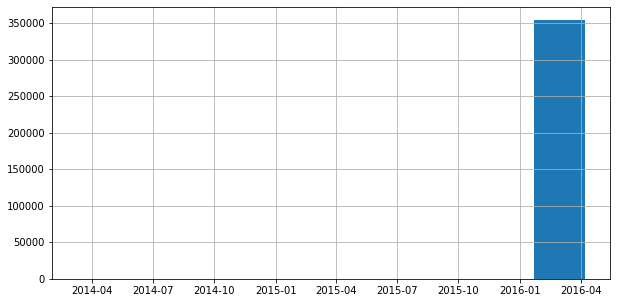

In [8]:
df['datecreated'] = pd.to_datetime(df['datecreated'])
df['datecreated'].hist(figsize=(10,5))
df['datecreated'].describe()

большинство данных анкеты было сделано март-апрель 2016. очевидно, что нам предоставили данные примерно за месяц


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Верно!
</div>

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: datecrawled, dtype: object

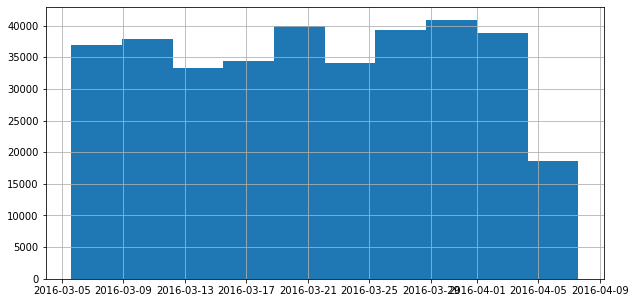

In [9]:
df['datecrawled'] = pd.to_datetime(df['datecrawled'])
df['datecrawled'].hist(figsize=(10,5))
df['datecrawled'].describe()


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Чтобы не налезали друг на друга значения на оси OX можно повернуть xticks на 45-90 градусов:)</div>

данные по скачиванию анкеты за месяц с падением к концу. распределены примерно равномерно

count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: lastseen, dtype: object

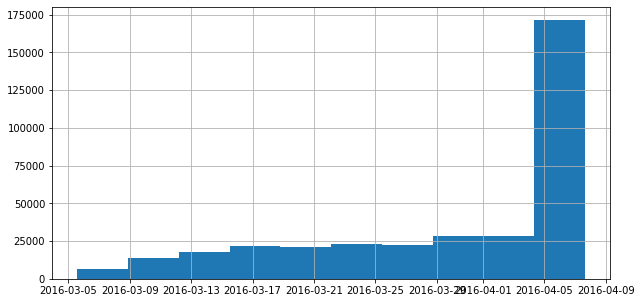

In [10]:
df['lastseen'] = pd.to_datetime(df['lastseen'])
df['lastseen'].hist(figsize=(10,5))
df['lastseen'].describe()

последняя активность за месяц

думаю, в данном случае признаки, связанные со временем стоит удалить, тк существенного влияния на обучение они не окажут. слишком маленький период для существенного изменения в цене на авто


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Верное замечание
</div>

In [11]:
df = df.drop(columns=['datecreated', 'datecrawled', 'lastseen'])
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

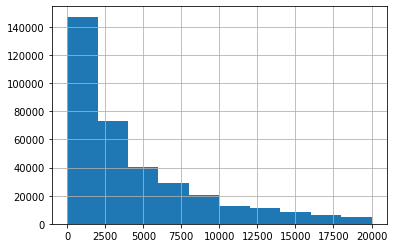

In [12]:
display(df['price'].describe())
df['price'].hist()


<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Забыл у части графиков легенду указать (название осей и самого графика;))</div>

исследовали значения по цене

In [13]:
df[df['price']==0]['price'].count()

10772

In [14]:
10772 / 354369

0.030397692800442477

In [15]:
df = df[df['price'] != 0]
df[df['price']==0]['price'].count()

0

цена - целевой признак. удалим нули, они явно тут не нужны.


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, это, видимо, машины, которые хотят бесплатно отдать, чтобы не платить налоги
</div>

In [16]:
df['registrationyear'].describe()

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

видим наличие мусорных значений, попробуем очистить от явных выбросов

In [17]:
np.percentile(df['registrationyear'], [1,99])

array([1980., 2018.])

In [18]:
df = df[df['registrationyear'] >= 1980]
df = df[df['registrationyear'] <= 2016]
df['registrationyear'].describe()

count    326652.000000
mean       2002.913719
std           6.029333
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Верное решение!
</div>

In [19]:
df['brand'].value_counts()

volkswagen        70312
opel              36379
bmw               34641
mercedes_benz     29934
audi              27594
ford              23235
renault           16391
peugeot           10398
fiat               8692
seat               6355
skoda              5281
mazda              5250
smart              4965
citroen            4742
nissan             4618
toyota             4384
hyundai            3397
mini               3051
volvo              3005
mitsubishi         2816
honda              2587
kia                2306
suzuki             2202
sonstige_autos     2140
alfa_romeo         2106
chevrolet          1564
chrysler           1305
dacia               865
daihatsu            749
subaru              715
porsche             671
jeep                605
daewoo              505
land_rover          504
saab                500
jaguar              474
rover               432
lancia              423
trabant             371
lada                188
Name: brand, dtype: int64

Далее подход будет идентичен к каждой колонке, в которой есть пропуски: определим наиболее частые значения в столбце и ими будем заполнять пропуски, соотнося со значением

In [20]:
df['model'].isna().sum()

14910

In [21]:
df[df['model'].isna()].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
220877,270,small,1995,manual,0,NaN,150000,11,petrol,opel,yes,0,27624
162030,2500,convertible,2000,auto,55,NaN,70000,9,petrol,smart,NaN,0,21514
326932,2000,NaN,2000,NaN,0,NaN,150000,0,NaN,opel,NaN,0,31675
138605,1150,small,1997,manual,101,NaN,150000,4,petrol,audi,no,0,52351
96262,1500,wagon,2001,manual,136,NaN,150000,0,gasoline,bmw,no,0,19055



<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
У метода sample всегда стоит фиксировать random_state, иначе не будет воспроизводимости</div>

In [22]:
top_model = df.groupby(['brand'])['model'].agg(pd.Series.mode).to_frame()
top_model.columns = ['top_model']
top_model = top_model.reset_index()
top_model.head()

,brand,top_model
0,alfa_romeo,156
1,audi,a4
2,bmw,3er
3,chevrolet,other
4,chrysler,other


In [23]:
df= df.merge(top_model, how='left')
df['model']=df['model'].fillna(df.top_model)
df['model']=df['model'].astype('str')
df['model'].isna().sum()

0

In [24]:
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,top_model
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,golf
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954,a4


In [25]:
df=df.drop(columns='top_model')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [26]:
df['vehicletype'].isna().sum()

19681

In [27]:
df[df['vehicletype'].isna()].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
102196,6200,NaN,2016,manual,150,passat,150000,6,NaN,volkswagen,NaN,0,86420
48232,2200,NaN,2016,manual,0,3er,150000,0,gasoline,bmw,NaN,0,90441
300501,550,NaN,2016,manual,45,corsa,150000,7,lpg,opel,no,0,48529
26093,2000,NaN,2016,manual,136,vectra,80000,2,petrol,opel,no,0,38368
283976,1400,NaN,2016,manual,85,passat,150000,0,NaN,volkswagen,no,0,34123


In [28]:
df['vehicletype'].value_counts()

sedan          88354
small          77735
wagon          63596
bus            28219
convertible    19448
coupe          15070
suv            11616
other           2933
Name: vehicletype, dtype: int64

заменим пропуски по самым частым маркам и моделям

In [29]:
vehicle_mode = df.groupby(['brand', 'model'])['vehicletype'].agg(pd.Series.mode).to_frame()
vehicle_mode.columns = ['vehicle_mode']
vehicle_mode = vehicle_mode.reset_index()
vehicle_mode.head()

,brand,model,vehicle_mode
0,alfa_romeo,145,small
1,alfa_romeo,147,sedan
2,alfa_romeo,156,sedan
3,alfa_romeo,159,wagon
4,alfa_romeo,other,coupe


In [30]:
df = df.merge(vehicle_mode, how='left')

заменим пропуски на самые часты для марки и модели

In [31]:
df['vehicletype'] = df['vehicletype'].fillna(df.vehicle_mode)
df['vehicletype'] = df['vehicletype'].astype('str')
df[df['vehicletype'].isna()]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,vehicle_mode



<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Допустимое решение, молодец;)
</div>

In [32]:
df = df.drop(columns='vehicle_mode')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [33]:
df['gearbox'].value_counts()

manual    249219
auto       62379
Name: gearbox, dtype: int64

In [34]:
df['gearbox'].isna().sum()

15054

In [35]:
gearbox_mode = df.groupby(['brand', 'model'])['gearbox'].agg(pd.Series.mode).to_frame()
gearbox_mode.columns = ['gearbox_mode']
gearbox_mode = gearbox_mode.reset_index()
gearbox_mode[gearbox_mode['gearbox_mode'].isna()]

,brand,model,gearbox_mode


In [36]:
df = df.merge(gearbox_mode, how='left')

In [37]:
df['gearbox'] = df['gearbox'].fillna(df.gearbox_mode)
df['gearbox'] = df['gearbox'].astype('str')
df['gearbox'].isna().sum()

0

In [38]:
df = df.drop(columns='gearbox_mode')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954


In [39]:
df['power'].describe()

count    326652.000000
mean        112.221186
std         183.348304
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

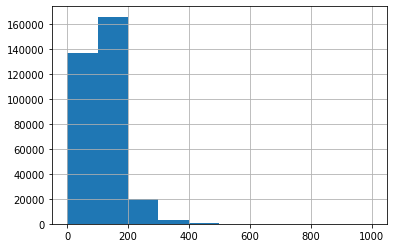

In [40]:
df['power'].hist(range=(0,1000))

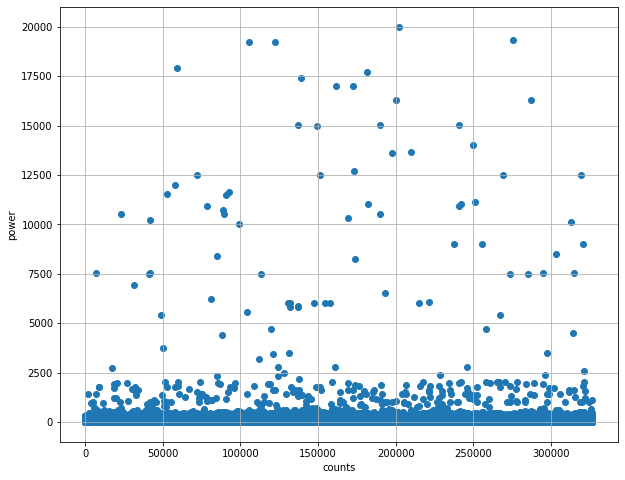

In [41]:
x_values = pd.Series(range(0, len(df)))
fig , ax = plt.subplots(figsize=(10,8))
ax.scatter(x= x_values, y=df['power'])
plt.xlabel('counts')
plt.ylabel('power')
plt.grid()
plt.show()

Очевидно, что очень немного машин приблизится по мощности к 1000лс и уж тем более крайне мало экземпляром будет больше 1000. Все , что больше 1000лс, удаляем. Остальные значения заполним привычным способом через медиану 


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Да, выбросы похоже на опечатки при заполнении объявлений
</div>

In [42]:
len(df[df['power']>1000])/len(df)

0.0007898313801844165

In [43]:
df = df[df['power']<1000]

In [44]:
len(df[df['power']==0])/len(df)

0.09794387712896495

In [45]:
df[df['power']==0].sample(5)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
71695,250,small,2016,manual,0,lupo,150000,11,NaN,volkswagen,NaN,0,87527
78864,250,small,2016,manual,0,clio,150000,0,petrol,renault,NaN,0,88630
152075,2000,small,2008,manual,0,i_reihe,150000,4,lpg,hyundai,NaN,0,59457
270866,1800,wagon,2000,manual,0,v70,150000,5,petrol,volvo,yes,0,58636
88792,295,wagon,1993,manual,0,c_klasse,5000,0,NaN,mercedes_benz,NaN,0,56575


In [46]:
med_power = df.groupby(['brand', 'model']).agg({'power':'median'})
med_power.columns = ['med_power']
med_power = med_power.reset_index()
med_power['med_power'] = med_power['med_power'].astype('int')

In [47]:
med_power[med_power['med_power']==0]

,brand,model,med_power
118,lada,samara,0
264,trabant,other,0


In [48]:
med_power.loc[med_power['brand']=='lada'].median()

med_power    76.5
dtype: float64

In [49]:
med_power.loc[med_power['model']=='samara','med_power'] = 76.5

In [50]:
med_power.loc[med_power['brand']=='trabant']

,brand,model,med_power
263,trabant,601,26.0
264,trabant,other,0.0


In [51]:
med_power.loc[med_power['brand']=='trabant','med_power'] = 26

In [52]:
med_power.loc[med_power['brand']=='trabant']

,brand,model,med_power
263,trabant,601,26.0
264,trabant,other,26.0


In [53]:
med_power[med_power['med_power']==0]

,brand,model,med_power


In [54]:
df = df.merge(med_power, how='left', on=['brand', 'model'])
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,med_power
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435,90.0
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,0,66954,140.0


In [55]:
df.loc[df['power']==0, 'power'] = df['med_power']

In [56]:
df[df['power']==0]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode,med_power


In [57]:
df = df.drop(columns='med_power')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954


In [58]:
df['kilometer'].describe()

count    326391.000000
mean     128605.231149
std       37131.076721
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

с пробегом, думаю все в порядке


<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Угу
</div>

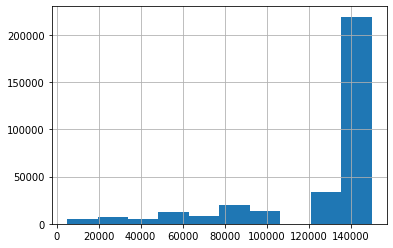

In [59]:
df['kilometer'].hist()

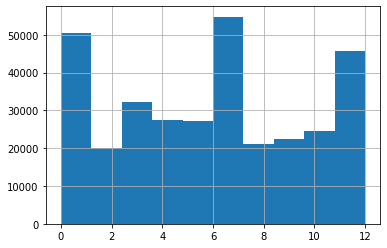

In [60]:
df['registrationmonth'].hist()

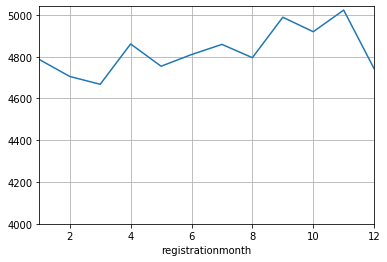

In [61]:
df[df['registrationmonth'] !=0 ].groupby('registrationmonth')['price'].mean().plot(grid=True,ylim=4000)

В общем небольшая корреляция между ценой и месяцем регистрации автомобиля есть


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Хм, сложно по графику это точно сказать, как мне кажется
</div>

In [62]:
df['fueltype'].value_counts()

petrol      202175
gasoline     94661
lpg           5000
cng            528
hybrid         220
other          137
electric        86
Name: fueltype, dtype: int64


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
А pertrol и gasoline не одно и тоже?</div>

In [63]:
df['fueltype'].isna().sum() / len(df)

0.07225689433838556


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Можно было проще, через mean
</div>

In [64]:
fuel_mode = df.groupby(['brand', 'model'])['fueltype'].agg(pd.Series.mode).to_frame()
fuel_mode.columns = ['fuel_mode']
fuel_mode = fuel_mode.reset_index()
fuel_mode[fuel_mode['fuel_mode'].isna()]

,brand,model,fuel_mode


In [65]:
df = df.merge(fuel_mode, how='left')

In [66]:
df['fueltype'] = df['fueltype'].fillna(df.fuel_mode)
df['fueltype'] = df['fueltype'].astype('str')
df['fueltype'].isna().sum()

0

In [67]:
df = df.drop(columns='fuel_mode')
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,0,60437


заполним пропущенные значения в поле "ремонтировалась ли" словом "нет"

In [68]:
df['notrepaired'] = df['notrepaired'].fillna('no')
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,numberofpictures,postalcode
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,no,0,70435
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes,0,66954


для обучения почовый индекс и наличие фотографии никой информации не даст, удаляем

In [69]:
df = df.drop(columns=['numberofpictures', 'postalcode'])
df.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,sedan,1993,manual,90.0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190.0,a4,125000,5,gasoline,audi,yes


добились ненулевых значений

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326391 entries, 0 to 326390
Data columns (total 11 columns):
price                326391 non-null int64
vehicletype          326391 non-null object
registrationyear     326391 non-null int64
gearbox              326391 non-null object
power                326391 non-null float64
model                326391 non-null object
kilometer            326391 non-null int64
registrationmonth    326391 non-null int64
fueltype             326391 non-null object
brand                326391 non-null object
notrepaired          326391 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 29.9+ MB


In [71]:
df.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'registrationmonth', 'fueltype', 'brand', 'notrepaired'],
      dtype='object')

In [72]:
time = df.copy()

посмотрим на зависимость категориальных признаков

In [73]:
encoder = OrdinalEncoder()
col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
encoder.fit(time[col])
time[col]=encoder.transform(time[col])

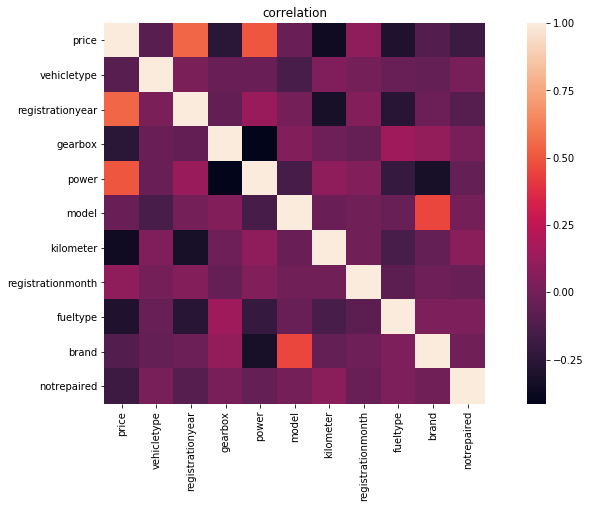

In [74]:
cm = time.corr()
plt.figure(figsize=(15,7))
plt.title('correlation')
sns.heatmap(cm, square=True, fmt='.lf')
plt.show()

сильной корреляции нет. ничего из признаков не будем удалять


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Я бы отметил, что год регистрации, пробег и мощность влияют, что логично
</div>

## Обучение моделей

В обучении будем использовать 3 модели: LinearRegressor, RandomForestRegressor и LGBMRegressor.

In [75]:
encoder = OrdinalEncoder()
col = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']
encoder.fit(time[col])
df[col]=encoder.transform(time[col])
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,4.0,1993,1.0,90.0,117.0,150000,0,6.0,38.0,0.0
1,18300,2.0,2011,1.0,190.0,30.0,125000,5,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163.0,118.0,125000,8,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75.0,117.0,150000,6,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69.0,102.0,90000,7,2.0,31.0,0.0



<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Так а что за нулевой месяц регистрации?)</div>


<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
А такой способ кодирования разве подходит для линейных моделей? Ведь создастся порядок там, где его раньше не было:)</div>

выделим целевой и обучающие признаки

In [76]:
x = df.drop('price', axis=1)
y = df['price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

масштабируем признаки для линейной регрессии

In [77]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_t = scaler.transform(x_train)
x_test_t = scaler.transform(x_test)
x_train_t = pd.DataFrame(x_train_t)
x_train_t.head()

,0,1,2,3,4,5,6,7,8,9
0,0.342037,0.677347,0.49382,-1.109657,-0.070007,-0.771787,-0.497734,0.680137,-0.809604,-0.333133
1,-0.137246,-1.978405,0.49382,0.313243,-0.169302,0.575895,0.589012,0.680137,-0.058212,-0.333133
2,0.342037,-0.650529,0.49382,-1.147102,-0.453000,-1.041324,-1.312793,0.680137,0.467762,3.001801
3,0.342037,0.345378,0.49382,-1.109657,-0.070007,0.575895,-1.584480,0.680137,-0.809604,3.001801
4,-0.137246,0.345378,0.49382,-0.192261,-1.389204,-0.097946,0.045639,0.680137,0.317483,-0.333133



<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Тут все гут
</div>

In [78]:
%%time
lr_model = LinearRegression()
lr_mse = cross_val_score(lr_model, x_train_t, y_train, cv = 5, scoring = make_scorer(mean_squared_error))
lr_rmse = (lr_mse**0.5).mean()
print('rmse', lr_rmse)

rmse 2890.5873869426314
CPU times: user 615 ms, sys: 521 ms, total: 1.14 s
Wall time: 1.1 s


Результаты у LinearRegressor быстрые, но нестоль хороши, судя по ошибке

Методом перебора подберем оптимальные значения для RandomForestRegressor

In [79]:
%%time
best_model_forest = None
rmse_forest = 4000
best_est = 0
best_depth = 0
for est in range(35, 50, 5):
    for depth in range (5, 10, 1):
        model = RandomForestRegressor(random_state=12345, n_estimators=est ,max_depth=depth)
        mse = cross_val_score(model, x_train, y_train, cv = 5, scoring = make_scorer(mean_squared_error))

        rmse = (mse**0.5).mean()
        if rmse < rmse_forest:
            best_model_forest = model
            rmse_forest = rmse
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели:", rmse_forest, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели: 1943.1171960606796 Количество деревьев: 45 Максимальная глубина: 9
CPU times: user 10min 30s, sys: 741 ms, total: 10min 31s
Wall time: 10min 32s


У случайного леса ошибка получше, попробуем LGBMRegressor

In [80]:
%%time
gbm_m = LGBMRegressor(random_state=12345)
mse_gbm = cross_val_score(gbm_m, x_train, y_train, scoring = make_scorer(mean_squared_error), cv = 5, n_jobs=-1)
rmse_gbm = (mse_gbm**0.5).mean()
print('rmse', rmse_gbm)

rmse 1704.2045769608012
CPU times: user 34 s, sys: 366 ms, total: 34.4 s
Wall time: 34.6 s



<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Все гут, аккуратно и четко
</div>

## Анализ моделей

In [81]:
%%time
lr_model = LinearRegression()
lr_model.fit(x_train_t, y_train)
lr_predict = lr_model.predict(x_test_t)
lr_rmse = (mean_squared_error(y_test, lr_predict)**0.5).mean()
print('средняя цена', lr_predict.mean())
print('rmse', lr_rmse)

средняя цена 4574.653829023317
rmse 2887.8836681933094
CPU times: user 77.3 ms, sys: 43.4 ms, total: 121 ms
Wall time: 104 ms


In [82]:
%%time
forest_model = RandomForestRegressor(random_state=12345, n_estimators=45 ,max_depth=9)
forest_model.fit(x_train, y_train)
forest_predict = forest_model.predict(x_test)
forest_rmse = (mean_squared_error(y_test, forest_predict)**0.5).mean()
print('средняя цена', forest_predict.mean())
print('rmse', forest_rmse)

средняя цена 4579.2251840591025
rmse 1936.721235703152
CPU times: user 14.9 s, sys: 47.7 ms, total: 15 s
Wall time: 15 s



<div class="alert alert-success">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Бейзлайн успешно побит, поздравляю!
</div>

In [83]:
%%time
gbm_model = LGBMRegressor(random_state=12345)
gbm_model.fit(x_train, y_train)
gbm_predict = gbm_model.predict(x_test)
gbm_rmse = (mean_squared_error(y_test, gbm_predict)**0.5).mean()
print('средняя цена', gbm_predict.mean())
print('rmse', gbm_rmse)

средняя цена 4577.913182403787
rmse 1687.6688175816814
CPU times: user 8.48 s, sys: 52.7 ms, total: 8.53 s
Wall time: 8.56 s


В заключение можно сказать об отличной скорости в 10,3с и самой низкой ошибкой в 1687 rmse у LGBMRegressor. На втором месте RandomForestRegressor с ошибкой rmse 1936 и скоростью 18.8 (учитывая известные показатели преднастройки). Самый плохой результат оказался у Линейной Регрессии с rmse 2887, но работает быстрее всех.


<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Полезно было бы еще:
    
    - добавить сводную табличку с результатами
    
    - реализовать дамми модель для сравнения
</div>

## Чек-лист проверки

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

-Спасибо за качественно сделанный проект, было приятно проверять. 

- Видно, что приложено много усилий

- Код написан хорошо

- Соблюдена структура проекта 
    
- Твои модели смогли достичь хорошего качества, поздравляю!
    
Есть пара небольшие замечаний и советов, учти их в следующих проектах:)
    
И удачи!)


</div>

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей